<a href="https://colab.research.google.com/github/adhamrait/uncategorized_projects/blob/main/AM160_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from ipywidgets import interact
import torch
from google.colab import drive
from os import listdir
from scipy.io import netcdf_file
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.animation as animation
from matplotlib import rc
import random
rc('animation', html='jshtml')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading/cleaning

In [ ]:
raw_data = {}
normalized_data = []
data_directory = "/content/drive/My Drive/AM160_Final_data"
for filename in listdir(data_directory):
  year = int(filename.split('.')[0].split('z')[1])
  print(f"loading year {year}...")
  with netcdf_file(f'{data_directory}/{filename}', 'r') as f:
    raw_data[year] = f.variables['z'][:].copy()
  print(raw_data[year].shape)

loading year 1979...
(1460, 2, 91, 180)
loading year 1980...
(1464, 2, 91, 180)
loading year 1981...
(1460, 2, 91, 180)
loading year 1983...
(1460, 2, 91, 180)
loading year 1985...
(1460, 2, 91, 180)


In [ ]:
year_indeces = {}
cur_index = 0
for year, data in raw_data.items():
  year_indeces[year] = range(cur_index, cur_index+len(data))
  cur_index += len(data)

In [ ]:
normalized_data = {}
for year, data in raw_data.items():
  mean = np.mean(data, axis=(0), keepdims=True)
  std = np.std(data, axis=(0), keepdims=True)
  normalized_data[year] = ((data - mean) / std).astype(float)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
training_years = [1979, 1980, 1981, 1983]
training_data = np.vstack([normalized_data[year] for year in training_years]).astype(float)
print(training_data.dtype)

float64


# Visualize the data

In [ ]:
def visualize(data):
  fig, axes = plt.subplots(2,1)
  axes[0].imshow(data[0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[1].imshow(data[1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[0].axis('off')
  axes[1].axis('off')
  plt.tight_layout()
  return

In [ ]:
interact(lambda t, year: visualize(normalized_data[year][t]), t=(0,len(normalized_data[1979]) -1), year=[year for year in normalized_data.keys()])

interactive(children=(IntSlider(value=729, description='t', max=1459), Dropdown(description='year', options=(1…

<function __main__.<lambda>(t, year)>

# VAE

In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1)  # (2, 91, 180) -> (32, 46, 90)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # (32, 46, 90) -> (64, 23, 45)
    self.fc1 = nn.Linear(64 * 23 * 45, 400)  # Flatten the output for fully connected layer
    self.fc2_mean = nn.Linear(400, latent_dim)  # Mean of the latent distribution
    self.fc2_logvar = nn.Linear(400, latent_dim)  # Log variance of the latent distribution

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.size(0), -1)  # Flatten the output for fully connected layer
    h1 = F.relu(self.fc1(x))
    z_mean = self.fc2_mean(h1)
    z_logvar = self.fc2_logvar(h1)
    return z_mean, z_logvar

class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super(Decoder, self).__init__()
    self.fc1 = nn.Linear(latent_dim+1, 400)  # Fully connected layer for latent dimension
    self.fc2 = nn.Linear(400, 64 * 23 * 45)  # Reshape to (64, 23, 45)
    self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # (64, 23, 45) -> (32, 46, 90)
    self.deconv2 = nn.ConvTranspose2d(32, 2, kernel_size=3, stride=2, padding=1, output_padding=1)  # (32, 46, 90) -> (2, 92, 180)

  def forward(self, z, k):
    # print(z.shape)
    # print(k.shape)
    x = F.relu(self.fc1(torch.cat([z, k], axis=1)))  # Apply fully connected layer
    x = F.relu(self.fc2(x))  # Apply another fully connected layer
    x = x.view(x.size(0), 64, 23, 45)  # Reshape to (64, 23, 45)
    x = F.relu(self.deconv1(x))  # Apply first deconvolution (transposed convolution)
    recon_x = torch.tanh(self.deconv2(x))  # Sigmoid activation to ensure output is in range [0, 1]
    return recon_x

# Denoising VAE with Convolutional Encoder and Decoder
class DenoisingVAE(nn.Module):
  def __init__(self, latent_dim):
    super(DenoisingVAE, self).__init__()
    self.encoder = Encoder(latent_dim)
    self.decoder = Decoder(latent_dim)

  def reparameterize(self, mean, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mean + eps * std

  def forward(self, x, k):
    z_mean, z_logvar = self.encoder(x)
    z = self.reparameterize(z_mean, z_logvar)
    recon_x = self.decoder(z, k)
    return recon_x, z_mean, z_logvar

In [ ]:
# Loss Function (ELBO)
def loss_function(recon_x, x, z_mean, z_logvar):
  loss = F.mse_loss(recon_x, x, reduction='sum')
  # KL Divergence
  KL_div = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())

  return loss + KL_div

# Part 1: Denoising VAE

In [ ]:
def sparsify(data, k):
    # Flatten the tensor and get the indices of the elements to sparsify
    # print(data.shape)
    # print(k.shape)
    ret_data = data.clone()
    if len(k) == 1:
      flattened_size = data[0].numel()
      num_elements_to_zero = int(k[0] * flattened_size)


      indices = torch.randperm(flattened_size)[:num_elements_to_zero]

      ret_data[0].view(-1)[indices] = 0
      ret_data[1].view(-1)[indices] = 0
    else:
      for i in range(len(k)):
        flattened_size = data[i][0].numel()
        num_elements_to_zero = int(k[i] * flattened_size)

        indices = torch.randperm(flattened_size)[:num_elements_to_zero]

        ret_data[i][0].view(-1)[indices] = 0
        ret_data[i][1].view(-1)[indices] = 0
    return ret_data

In [ ]:
interact(lambda k: visualize(sparsify(torch.from_numpy(normalized_data[1980][0]), k)), k=(0.0,1.0))

interactive(children=(FloatSlider(value=0.5, description='k', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.<lambda>(k)>

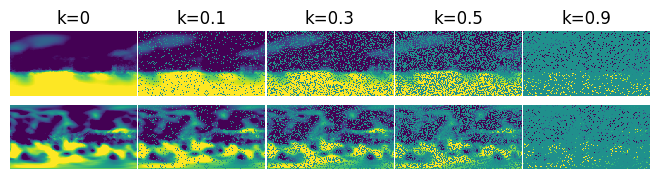

In [ ]:
def visualize_thing(axes, data):
  axes[0].imshow(data[0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[1].imshow(data[1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[0].axis('off')
  axes[1].axis('off')

fig, axes = plt.subplots(2, 5)
for i, k in enumerate([0, 0.1, 0.3, 0.5, 0.9]):
  axes[0,i].set_title(f"k={k}")
  visualize_thing(axes[:,i], sparsify(torch.from_numpy(normalized_data[1980][0]), [k]))
plt.tight_layout(pad=0, w_pad=0.1, h_pad=-15)

In [ ]:
latent_dim = 1000
learning_rate = 1e-3
batch_size = 16
epochs = 10

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Training Loop
model = DenoisingVAE(latent_dim=200).to(device)  # Move model to device (CUDA or CPU)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(training_loader):
        data = data.to(device).float()
        k = torch.rand(data.shape[0], 1).to(device)
        sparse_data = sparsify(data, k)

        optimizer.zero_grad()

        # Forward pass
        recon_batch, z_mean, z_logvar = model(sparse_data.float(), torch.rand(data.shape[0], 1).to(device))
        # Crop output
        recon_batch = recon_batch[:, :, :91, :]


        loss = loss_function(recon_batch, data - sparse_data, z_mean, z_logvar)
        loss.backward()

        # Update weights
        optimizer.step()

        train_loss += loss.item()
        losses.append(loss.item())
        # if batch_idx % 100 == 0:
        #     print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(training_loader)}, Loss: {loss.item()/len(data)}")

    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {train_loss / len(training_loader.dataset)}")

Epoch 1/10, Average Loss: 11412.331907592188
Epoch 2/10, Average Loss: 9792.379584696911
Epoch 3/10, Average Loss: 9262.437481284223
Epoch 4/10, Average Loss: 9197.010825071655
Epoch 5/10, Average Loss: 8779.592087972173
Epoch 6/10, Average Loss: 8607.712281025411
Epoch 7/10, Average Loss: 8354.626403014845
Epoch 8/10, Average Loss: 8102.040851861952
Epoch 9/10, Average Loss: 8025.4860884962145
Epoch 10/10, Average Loss: 7955.089624842252


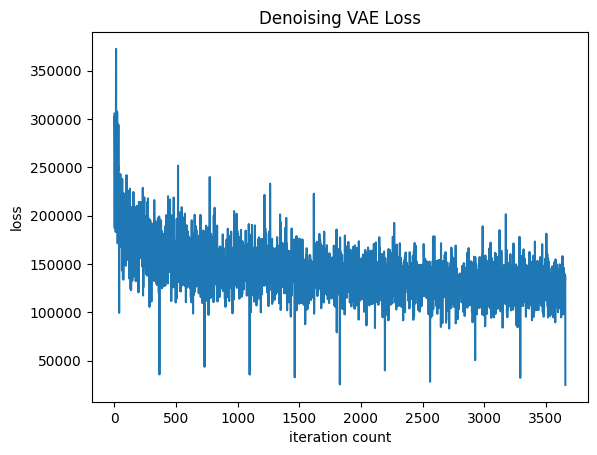

In [ ]:
def plot_loss_graph(losses):
  plt.plot(losses)
  plt.ylabel("loss")
  plt.xlabel("iteration count")
plt.title("Denoising VAE Loss")
plot_loss_graph(losses)

In [ ]:
model.eval()
def visualize_output(data, k):
  fig, axes = plt.subplots(2,3)
  axes[0,0].set_title('expected')
  axes[0,0].imshow(data[0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[1,0].imshow(data[1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[0,0].axis('off')
  axes[1,0].axis('off')

  sparsified = sparsify(data, k)
  axes[0,1].set_title('sparsified')
  axes[0,1].imshow(sparsified[0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[1,1].imshow(sparsified[1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[0,1].axis('off')
  axes[1,1].axis('off')

  dev = sparsified.float().to(device).unsqueeze(0)
  def L(val):
    output, _,_ = model(val, torch.from_numpy(np.array([k])).float().to(device))
    return output[0,:,:91]
  output = euler_step(dev, L)[0].cpu().detach()
  axes[0,2].set_title('output')
  axes[0,2].imshow(output[0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[1,2].imshow(output[1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[0,2].axis('off')
  axes[1,2].axis('off')
  plt.tight_layout()
  plt.tight_layout(pad=0, w_pad=0.1, h_pad=-5)
  fig.suptitle(f"k={k}", y=0.85)
interact(lambda t, k, r: visualize_output(torch.from_numpy(normalized_data[1985][t]), [k]), t=(0, 1460-1), k=(0,1.0), r=(0,1))

interactive(children=(IntSlider(value=729, description='t', max=1459), FloatSlider(value=0.5, description='k',…

<function __main__.<lambda>(t, k, r)>

In [ ]:
errors = {}
for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
  errors[k] = []
for data in normalized_data[1985]:
  data = torch.from_numpy(data)
  for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
    sparsified = sparsify(data, [k])
    dev = sparsified.float().to(device).unsqueeze(0)
    output, _,_ = model(dev, torch.from_numpy(np.array([[k]])).float().to(device))
    output = output[:, :91, :].cpu().detach()[0,:,:91]
    def L(val):
      output, _,_ = model(val, torch.from_numpy(np.array([[k]])).float().to(device))
      return output[0,:,:91]
    output = euler_step(dev, L)[0].cpu().detach()
    errors[k].append(torch.mean((output- data)**2) )

In [ ]:
errors_rk4 = {}
for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
  errors_rk4[k] = []
for data in normalized_data[1985]:
  data = torch.from_numpy(data)
  for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
    sparsified = sparsify(data, [k])
    dev = sparsified.float().to(device).unsqueeze(0)
    output, _,_ = model(dev, torch.from_numpy(np.array([[k]])).float().to(device))
    output = output[:, :91, :].cpu().detach()[0,:,:91]
    def L(val):
      output, _,_ = model(val, torch.from_numpy(np.array([[k]])).float().to(device))
      return output[0,:,:91]
    output = rk4_step(dev, L)[0].cpu().detach()
    errors_rk4[k].append(torch.mean((output- data)**2) )

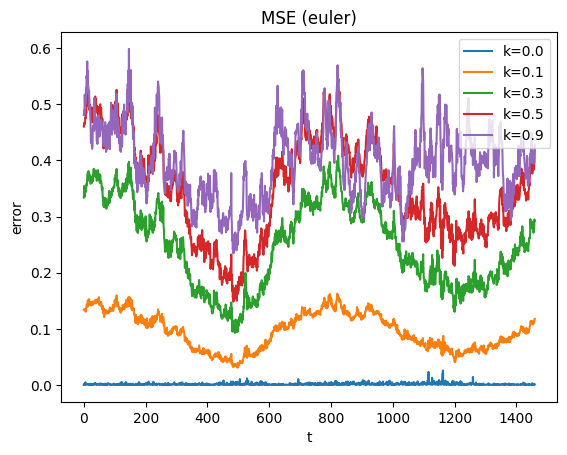

In [ ]:
for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
  plt.plot(errors[k], label=f"k={k}")
  plt.legend()
  plt.title("MSE (euler)")
  plt.ylabel("error")
  plt.xlabel("t")

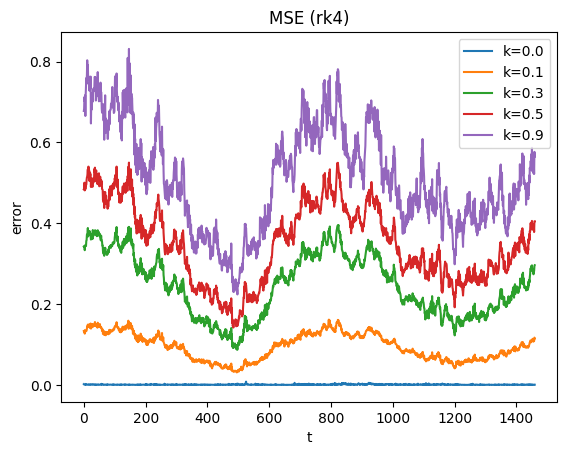

In [ ]:
for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
  plt.plot(errors_rk4[k], label=f"k={k}")
  plt.legend()
  plt.title("MSE (rk4)")
  plt.ylabel("error")
  plt.xlabel("t")

In [ ]:
# Training Loop
model = DenoisingVAE(latent_dim=200).to(device)  # Move model to device (CUDA or CPU)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(training_loader):
        data = data.to(device).float()
        k = torch.rand(data.shape[0], 1).to(device)
        sparse_data = sparsify(data, k)

        optimizer.zero_grad()

        # Forward pass
        recon_batch, z_mean, z_logvar = model(sparse_data.float(), k)
        # Crop output
        recon_batch = recon_batch[:, :, :91, :]


        loss = loss_function(recon_batch, data, z_mean, z_logvar)
        loss.backward()

        # Update weights
        optimizer.step()

        train_loss += loss.item()
        losses.append(loss.item())
        # if batch_idx % 100 == 0:
        #     print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(training_loader)}, Loss: {loss.item()/len(data)}")

    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {train_loss / len(training_loader.dataset)}")

Epoch 1/10, Average Loss: 15276.664367968215
Epoch 2/10, Average Loss: 11473.576230696013
Epoch 3/10, Average Loss: 9923.316656907726
Epoch 4/10, Average Loss: 8601.649867251668
Epoch 5/10, Average Loss: 7638.827709910806
Epoch 6/10, Average Loss: 6780.104148953521
Epoch 7/10, Average Loss: 6329.895496115139
Epoch 8/10, Average Loss: 6068.401932002909
Epoch 9/10, Average Loss: 5975.795921832221
Epoch 10/10, Average Loss: 5699.693956274597


In [ ]:
interact(lambda t, k, r: visualize_output(torch.from_numpy(normalized_data[1985][t]), [k]), t=(0, 1460-1), k=(0,1.0), r=(0,1))

interactive(children=(IntSlider(value=729, description='t', max=1459), FloatSlider(value=0.5, description='k',…

<function __main__.<lambda>(t, k, r)>

In [ ]:
errors = {}
for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
  errors[k] = []
for data in normalized_data[1985]:
  data = torch.from_numpy(data)
  for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
    sparsified = sparsify(data, [k])
    dev = sparsified.float().to(device).unsqueeze(0)
    output, _,_ = model(dev, torch.from_numpy(np.array([[k]])).float().to(device))
    output = output[:, :91, :].cpu().detach()[0,:,:91]
    errors[k].append(torch.mean((output- data)**2) )

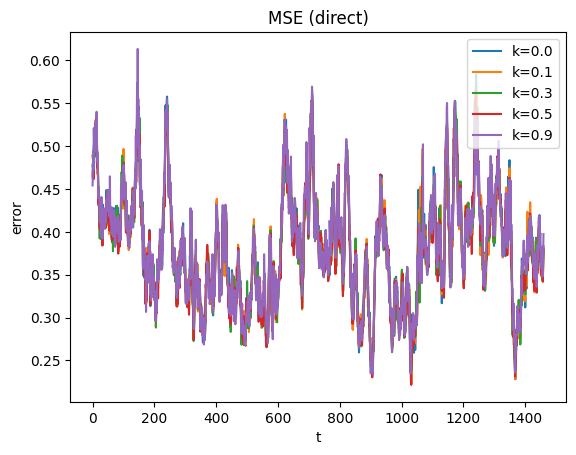

In [ ]:
for k in [0.0, 0.1, 0.3, 0.5, 0.9]:
  plt.plot(errors[k], label=f"k={k}")
  plt.legend()
  plt.title("MSE (direct)")
  plt.ylabel("error")
  plt.xlabel("t")

# Part 2: Autoregressive Diffusion Model

In [ ]:
input_shape = (2, 91, 180)
learning_rate = 1e-3
batch_size = 16
epochs = 20
latent_dim = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x_t = self.data[idx]  # X(t)
        x_t_plus_1 = self.data[idx+1]  # X(t+1)
        return x_t, x_t_plus_1, idx % 1464


time_series = TimeSeriesDataset(training_data, 1)
training_loader = DataLoader(time_series, batch_size=batch_size, shuffle=True)

## Conditioned on day of year

In [ ]:
# Training Loop
model = DenoisingVAE(latent_dim=latent_dim).to(device)  # Move model to device (CUDA or CPU)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
  model.train()
  train_loss = 0
  # Loop through batches of data
  for batch_idx, (previous_x, x, t) in enumerate(training_loader):
    x = x.to(device).float()
    previous_x = previous_x.to(device).float()
    t = t.to(device).float().reshape(-1, 1)
    # print(x_0.shape)

    optimizer.zero_grad()

    # Forward pass
    recon_batch, z_mean, z_logvar = model(previous_x, t)
    # Crop output
    recon_batch = recon_batch[:, :, :91, :]

    loss = loss_function(recon_batch, x-previous_x, z_mean, z_logvar)
    loss.backward()

    # Update weights
    optimizer.step()

    train_loss += loss.item()
    # if batch_idx % 100 == 0:
    #     print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(training_loader)}, Loss: {loss.item()/len(data)}")

  print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {train_loss / len(training_loader.dataset)}")

Epoch 1/20, Average Loss: 2635.776633849398
Epoch 2/20, Average Loss: 1445.6593962928398
Epoch 3/20, Average Loss: 1424.7339550764536
Epoch 4/20, Average Loss: 1383.8143159081915
Epoch 5/20, Average Loss: 1408.817681313377
Epoch 6/20, Average Loss: 1437.6778336524474
Epoch 7/20, Average Loss: 1374.9278662017452
Epoch 8/20, Average Loss: 1383.174027849831
Epoch 9/20, Average Loss: 1411.081243047236
Epoch 10/20, Average Loss: 1379.7576501713456
Epoch 11/20, Average Loss: 1358.028648981019
Epoch 12/20, Average Loss: 1373.1065506903292
Epoch 13/20, Average Loss: 1350.1397781332898
Epoch 14/20, Average Loss: 1322.2562790478457
Epoch 15/20, Average Loss: 1290.674926569787
Epoch 16/20, Average Loss: 1296.1273720457439
Epoch 17/20, Average Loss: 1285.082212924386
Epoch 18/20, Average Loss: 1273.3960975857196
Epoch 19/20, Average Loss: 1295.2659779864796
Epoch 20/20, Average Loss: 1231.665912169209


In [ ]:
def rk4_step(old, L):
  k1 = L(old)
  k2 = L(k1/2 + old)
  k3 = L(k2/2 + old)
  k4 = L(k3 + old)
  return old + 1/6*(k1 + 2*k2 + 2*k3 + k4)
def euler_step(old, L):
  return L(old) + old

model.eval()
eval_steps = 50
model_time_series = [normalized_data[1985][0]]
sample_number = len(normalized_data[1985])

for t in range(eval_steps):
  def L(y):
    output, _,_ = model(y, torch.tensor([[t]]).float().to(device))
    return output[:,:, :91, :]
  # k1, _,_ = model(torch.from_numpy(model_time_series[-1]).float().to(device).unsqueeze(0), torch.tensor([[t]]).float().to(device))
  model_time_series.append(euler_step(torch.from_numpy(model_time_series[-1]).float().to(device).unsqueeze(0), L).detach().cpu().numpy()[0])

In [ ]:
def visualize_comparison(normalized_data, model_time_series, t):
  fig, axes = plt.subplots(2,2)
  fig.suptitle(f"t={t}")
  axes[0,0].set_title('Expected')
  axes[0,0].imshow(normalized_data[t][0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[1,0].imshow(normalized_data[t][1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[0,0].axis('off')
  axes[1,0].axis('off')

  axes[0,1].set_title('Output')
  axes[0,1].imshow(model_time_series[t][0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[1,1].imshow(model_time_series[t][1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
  axes[0,1].axis('off')
  axes[1,1].axis('off')

  plt.tight_layout()
  # print(F.mse_loss(output[:, :91, :], data).numpy())

In [ ]:
interact(lambda t: visualize_comparison(normalized_data, model_time_series, t), t=(0, eval_steps-1))

interactive(children=(IntSlider(value=249, description='t', max=499), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(t)>

## Random Conditioning + ensemble

In [ ]:
# Training Loop
model_ensemble = DenoisingVAE(latent_dim=latent_dim).to(device)  # Move model to device (CUDA or CPU)
optimizer = optim.Adam(model_ensemble.parameters(), lr=learning_rate)
for epoch in range(epochs):
  model_ensemble.train()
  train_loss = 0
  # Loop through batches of data
  for batch_idx, (previous_x, x, _) in enumerate(training_loader):
    x = x.to(device).float()
    previous_x = previous_x.to(device).float()
    r = torch.rand((len(x), 1)).to(device).float().reshape(-1, 1)
    # print(x_0.shape)

    optimizer.zero_grad()

    # Forward pass
    recon_batch, z_mean, z_logvar = model_ensemble(previous_x, r)
    # Crop output
    recon_batch = recon_batch[:, :, :91, :]

    loss = loss_function(recon_batch, x-previous_x, z_mean, z_logvar)
    loss.backward()

    # Update weights
    optimizer.step()

    train_loss += loss.item()
    # if batch_idx % 100 == 0:
    #     print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(training_loader)}, Loss: {loss.item()/len(data)}")

  print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {train_loss / len(training_loader.dataset)}")

Epoch 1/20, Average Loss: 1973.6677894990532
Epoch 2/20, Average Loss: 1448.4949059304404
Epoch 3/20, Average Loss: 1435.7807795602778
Epoch 4/20, Average Loss: 1422.3335955801147
Epoch 5/20, Average Loss: 1407.636909867443
Epoch 6/20, Average Loss: 1367.0037538240201
Epoch 7/20, Average Loss: 1384.5389044750395
Epoch 8/20, Average Loss: 1342.6367881105061
Epoch 9/20, Average Loss: 1306.0362378978452
Epoch 10/20, Average Loss: 1308.524918305023
Epoch 11/20, Average Loss: 1300.5557243142168
Epoch 12/20, Average Loss: 1281.76707647305
Epoch 13/20, Average Loss: 1244.9048223852928
Epoch 14/20, Average Loss: 1240.7374569463461
Epoch 15/20, Average Loss: 1250.7375950406067
Epoch 16/20, Average Loss: 1224.9529399411556
Epoch 17/20, Average Loss: 1217.4769766992154
Epoch 18/20, Average Loss: 1234.1282270602244
Epoch 19/20, Average Loss: 1234.8956280234495
Epoch 20/20, Average Loss: 1214.2650779294536


In [ ]:
model_ensemble.eval()

In [ ]:
def euler_step(old, L):
  return old + L(old)

def rk4_step(old, L):
  k1 = L(old)
  k2 = L(old + 0.5 * k1)
  k3 = L(old + 0.5 * k2)
  k4 = L(old + k3)
  return old + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def ensemble(step, steps, sample_number, model_ensemble):
  model_ensemble_time_series = [torch.from_numpy(normalized_data[1985][0]).float().to(device).unsqueeze(0)]
  for t in range(steps):
    def L(y):
      ensemble = []
      prev = model_ensemble_time_series[-1]
      for _ in range(sample_number):
        # print(model_ensemble_time_series[-1].shape, t)
        r = torch.tensor([[random.random()]]).float().to(device)
        output, _,_ = model_ensemble(prev, r)
        ensemble.append(output[:,:, :91, :].cpu().detach())
      return torch.mean(torch.stack(ensemble), axis=0)[:,:, :91].to(device)
    if t%200 == 0: print(t)
    model_ensemble_time_series.append(step(model_ensemble_time_series[-1], L).to(device))
  return  torch.stack(model_ensemble_time_series).squeeze(1).cpu()

In [ ]:
eval_steps = 500
sample_number = 10
euler_step_ensemble = ensemble(euler_step, eval_steps, sample_number, model_ensemble)
rk4_ensemble = ensemble(rk4_step, eval_steps, sample_number, model_ensemble)

0
200
400
0
200
400


In [ ]:
interact(lambda t: visualize_comparison(normalized_data[1985], rk4_ensemble, t), t=(0, eval_steps-1))

interactive(children=(IntSlider(value=249, description='t', max=499), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(t)>

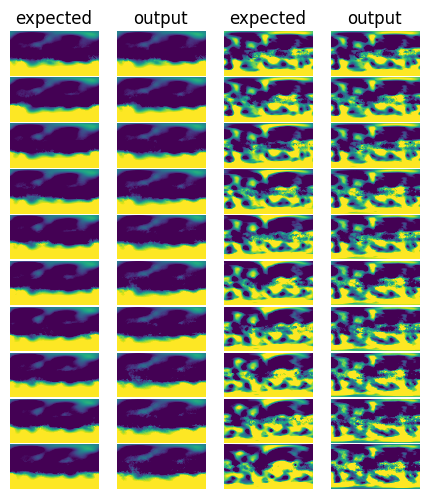

In [ ]:
def visualize_comparison_trend(normalized_data, model_time_series, tmax):
  for t in range(tmax):
    plt.subplot(10,4,t*4+1)
    plt.imshow(normalized_data[t][0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
    plt.axis('off')
    if t==0: plt.title("expected")

    plt.subplot(10,4,t*4+3)
    plt.imshow(normalized_data[t][1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
    plt.axis('off')
    if t==0: plt.title("expected")

    plt.subplot(10,4,t*4+2)
    plt.imshow(model_time_series[t][0], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
    plt.axis('off')
    if t==0: plt.title("output")

    plt.subplot(10,4,t*4+4)
    plt.imshow(model_time_series[t][1], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
    plt.axis('off')
    if t==0: plt.title("output")
plt.figure()
visualize_comparison_trend(normalized_data[1985], euler_step_ensemble, 10)
plt.tight_layout(pad=0, w_pad=-12, h_pad=0.1)


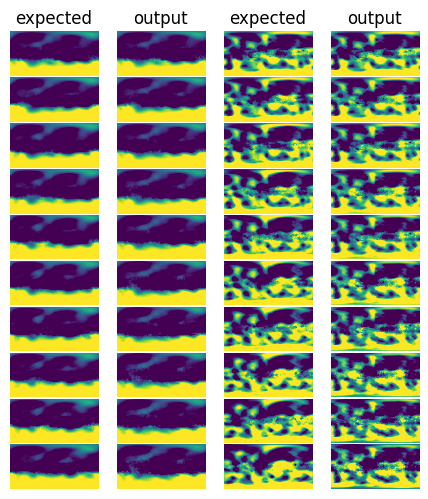

In [ ]:
plt.figure()
visualize_comparison_trend(normalized_data[1985], rk4_ensemble, 10)
plt.tight_layout(pad=0, w_pad=-12, h_pad=0.1)


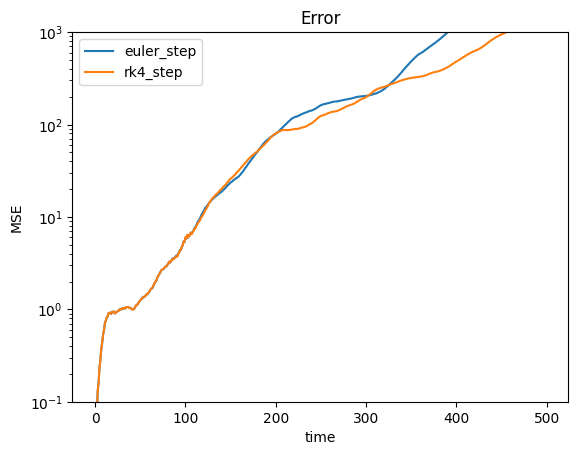

In [ ]:
def compare_error(expected, actual, T, label):
  # [print(expected[i].shape, actual[i].shape) for i in T]
  error =  [np.mean((expected[t]- actual[t])**2) for t in T]
  plt.plot(T,error, label=label)
  plt.xlabel("time")
  plt.ylabel("MSE")
  plt.yscale('log')
  plt.ylim((1e-1, 1e3))
compare_error(normalized_data[1985], euler_step_ensemble.detach().numpy(), range(eval_steps), "euler_step")
compare_error(normalized_data[1985], rk4_ensemble.detach().numpy(), range(eval_steps), "rk4_step")
plt.title("Error")
plt.legend()

## proper latent space

In [ ]:
class ForwardVAE(nn.Module):
    def __init__(self, l_input_dim):
        super(ForwardVAE, self).__init__()

        # Convolutional layers with downsampling (using strided convolutions)
        self.conv1 = nn.Conv2d(in_channels=2*l_input_dim, out_channels=32, kernel_size=3, stride=2, padding=1)  # Stride of 2 for downsampling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)  # Stride of 2 for downsampling
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)  # Stride of 2 for downsampling

        # After three convolutions with stride 2, the feature map size will be reduced from
        # (2, 91, 180) to (2, 11, 22) (approximately), which reduces the memory cost.

        # Fully connected layers
        # After convolution, the spatial dimensions will be (l, 128 * 12 * 23)
        self.fc1 = nn.Linear(128 * 12 * 23+1, 1024)  # Flattened to (l, 128 * 12 * 23)
        self.fc2 = nn.Linear(1024, 1024)  # Added 1 for the scalar input

        # Output layer to reshape into (2, 91, 180)
        self.fc_output = nn.Linear(1024, 2 * 91 * 180)

    def forward(self, x_image, x_scalar):
        # Apply conv layers with downsampling
        x = F.relu(self.conv1(x_image))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten the output from convolutional layers
        x = x.view(x.size(0), -1)  # Shape: (l, 128 * 11 * 22)

        # Concatenate the scalar input (assuming it's a tensor of shape (l, 1))
        x_scalar = x_scalar.view(x.size(0), -1)  # Make sure scalar is (l, 1)
        x = torch.cat((x, x_scalar), dim=1)  # Concatenate image features with scalar input

        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Get final output shape (l, 2 * 91 * 180)
        x = self.fc_output(x)

        # Reshape to (l, 2, 91, 180) as the desired output shape
        x = x.view(x.size(0), 2, 91, 180)

        return x

In [ ]:
# Training Loop
model_1_ts = ForwardVAE(1).to(device)  # Move model to device (CUDA or CPU)
optimizer = optim.Adam(model_1_ts.parameters(), lr=learning_rate)
for epoch in range(epochs):
  model_1_ts.train()
  train_loss = 0
  # Loop through batches of data
  for batch_idx, (previous_x, x, _) in enumerate(training_loader):
    x = x.to(device).float()
    previous_x = previous_x.to(device).float()
    r = torch.rand((len(x), 1)).to(device).float().reshape(-1, 1)
    # print(x_0.shape)

    optimizer.zero_grad()

    # Forward pass
    out = model_1_ts(previous_x, r)

    loss = F.mse_loss(out, x-previous_x)
    loss.backward()

    # Update weights
    optimizer.step()

    train_loss += loss.item()
    # if batch_idx % 100 == 0:
    #     print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(training_loader)}, Loss: {loss.item()/len(data)}")

  print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {train_loss / len(training_loader.dataset)}")

Epoch 1/20, Average Loss: 0.0028998310069311122
Epoch 2/20, Average Loss: 0.0023582577775515413
Epoch 3/20, Average Loss: 0.002160409529507415
Epoch 4/20, Average Loss: 0.001974854230352834
Epoch 5/20, Average Loss: 0.0019016397956598708
Epoch 6/20, Average Loss: 0.0018516658659786594
Epoch 7/20, Average Loss: 0.0018040653931503934
Epoch 8/20, Average Loss: 0.0017418983865331017
Epoch 9/20, Average Loss: 0.0016886660876685006
Epoch 10/20, Average Loss: 0.0016439670960487578
Epoch 11/20, Average Loss: 0.0016056168476961542
Epoch 12/20, Average Loss: 0.0015633846718410545
Epoch 13/20, Average Loss: 0.0015267099743323561
Epoch 14/20, Average Loss: 0.0014919503594345576
Epoch 15/20, Average Loss: 0.0014574493152595804
Epoch 16/20, Average Loss: 0.0014352950371257372
Epoch 17/20, Average Loss: 0.001417751445851158
Epoch 18/20, Average Loss: 0.0013881375649429115
Epoch 19/20, Average Loss: 0.0013650000282173877
Epoch 20/20, Average Loss: 0.0013507208744666154


In [ ]:
def ensemble_better(step, steps, sample_number, model_ensemble):
  model_ensemble_time_series = [torch.from_numpy(normalized_data[1985][0]).float().to(device).unsqueeze(0)]
  for t in range(steps):
    def L(y):
      ensemble = []
      prev = model_ensemble_time_series[-1]
      for _ in range(sample_number):
        # print(model_ensemble_time_series[-1].shape, t)
        r = torch.tensor([[random.random()]]).float().to(device)
        output= model_ensemble(prev, r)
        ensemble.append(output.cpu().detach())
      return torch.mean(torch.stack(ensemble), axis=0).to(device)
    if t%200 == 0: print(t)
    model_ensemble_time_series.append(step(model_ensemble_time_series[-1], L).to(device))
  return  torch.stack(model_ensemble_time_series).squeeze(1).cpu()

In [ ]:
model_1_ts.eval()


eval_steps = 500
sample_number = 10
euler_step_ensemble = ensemble_better(euler_step, eval_steps, sample_number, model_1_ts)
rk4_ensemble = ensemble_better(rk4_step, eval_steps, sample_number, model_1_ts)

0
200
400
0
200
400


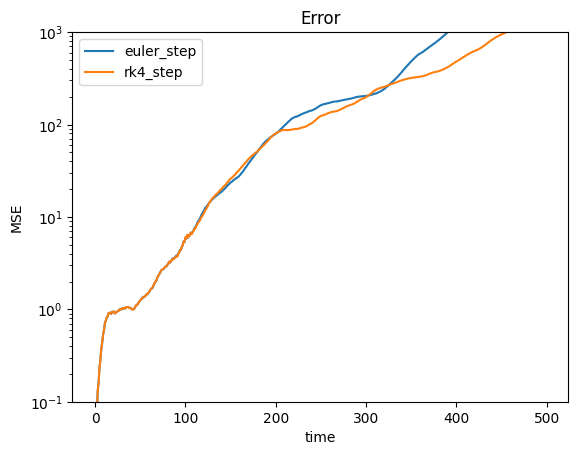

In [ ]:
compare_error(normalized_data[1985], euler_step_ensemble.detach().numpy(), range(eval_steps), "euler_step")
compare_error(normalized_data[1985], rk4_ensemble.detach().numpy(), range(eval_steps), "rk4_step")
plt.title("Error")
plt.legend()

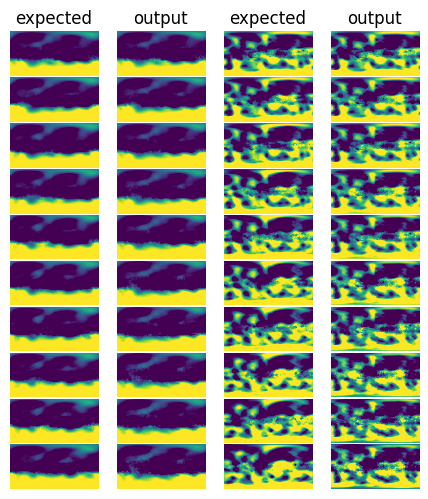

In [ ]:
plt.figure()
visualize_comparison_trend(normalized_data[1985], rk4_ensemble, 10)
plt.tight_layout(pad=0, w_pad=-12, h_pad=0.1)

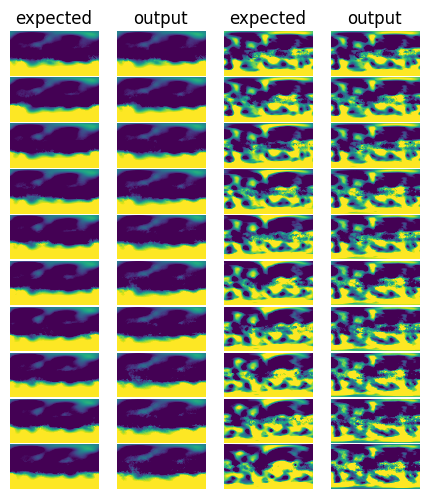

In [ ]:
visualize_comparison_trend(normalized_data[1985], euler_step_ensemble, 10)
plt.tight_layout(pad=0, w_pad=-12, h_pad=0.1)


## Multiple previous training points

In [ ]:
class TimeSeriesDatasetMany(Dataset):
    def __init__(self, data, l):
        self.data = data
        self.l = l

    def __len__(self):
        return len(self.data) - self.l

    def __getitem__(self, idx):
        x_t = self.data[idx:idx+self.l]  # X(t)
        x_t_plus_1 = self.data[idx+self.l]  # X(t+1)
        return x_t, x_t_plus_1, idx % 1464


time_series = TimeSeriesDatasetMany(training_data, 2)
training_loader = DataLoader(time_series, batch_size=batch_size, shuffle=True)

In [ ]:
# Training Loop
model_2_ts = ForwardVAE(2).to(device)  # Move model to device (CUDA or CPU)
optimizer = optim.Adam(model_2_ts.parameters(), lr=learning_rate)
for epoch in range(epochs):
  model_2_ts.train()
  train_loss = 0
  # Loop through batches of data
  for batch_idx, (previous_x, x, _) in enumerate(training_loader):
    x = x.to(device).float()
    previous_x = previous_x.to(device).float()
    r = torch.rand((len(x), 1)).to(device).float().reshape(-1, 1)
    # print(x_0.shape)

    optimizer.zero_grad()

    # Forward pass
    out = model_2_ts(previous_x.view(len(x), -1, 91, 180), r)

    loss = F.mse_loss(out, x-previous_x[:,-1])
    loss.backward()

    # Update weights
    optimizer.step()

    train_loss += loss.item()
    # if batch_idx % 100 == 0:
    #     print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(training_loader)}, Loss: {loss.item()/len(data)}")

  print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {train_loss / len(training_loader.dataset)}")

Epoch 1/20, Average Loss: 0.002471582846093039
Epoch 2/20, Average Loss: 0.002049607104242093
Epoch 3/20, Average Loss: 0.0019531892296927957
Epoch 4/20, Average Loss: 0.0019137534089399217
Epoch 5/20, Average Loss: 0.0018665553126401258
Epoch 6/20, Average Loss: 0.0018391261739386592
Epoch 7/20, Average Loss: 0.0017716233092157738
Epoch 8/20, Average Loss: 0.0017124637770085497
Epoch 9/20, Average Loss: 0.0016606894558635489
Epoch 10/20, Average Loss: 0.0016127701489097328
Epoch 11/20, Average Loss: 0.0015657262599879404
Epoch 12/20, Average Loss: 0.0015302904371716764
Epoch 13/20, Average Loss: 0.0014942241316098172
Epoch 14/20, Average Loss: 0.0014981729396450238
Epoch 15/20, Average Loss: 0.0014446348752807322
Epoch 16/20, Average Loss: 0.001406502720888083
Epoch 17/20, Average Loss: 0.0013822253550524297
Epoch 18/20, Average Loss: 0.0013675641492315246
Epoch 19/20, Average Loss: 0.0013450273506799939
Epoch 20/20, Average Loss: 0.0013196736683215192


In [ ]:
def ensemble_better_2(step, steps, sample_number, model_ensemble):
  model_ensemble_time_series = [torch.from_numpy(normalized_data[1985][0]).float().to(device).unsqueeze(0), torch.from_numpy(normalized_data[1985][1]).float().to(device).unsqueeze(0)]
  for t in range(steps):
    def L(y):
      ensemble = []
      prev = torch.stack([model_ensemble_time_series[-2], model_ensemble_time_series[-1]]).view( -1, 91, 180).unsqueeze(0)
      for _ in range(sample_number):
        # print(model_ensemble_time_series[-1].shape, t)
        r = torch.tensor([[random.random()]]).float().to(device)
        r = r.unsqueeze(0)
        output= model_ensemble(prev, r)
        ensemble.append(output.cpu().detach())
      return torch.mean(torch.stack(ensemble), axis=0).to(device)
    if t%200 == 0: print(t)
    model_ensemble_time_series.append(step(model_ensemble_time_series[-1], L).to(device))
  return  torch.stack(model_ensemble_time_series).squeeze(1).cpu()

In [ ]:
eval_steps = 500
sample_number = 10
euler_step_ensemble = ensemble_better_2(euler_step, eval_steps, sample_number, model_2_ts)
rk4_ensemble = ensemble_better_2(rk4_step, eval_steps, sample_number, model_2_ts)

0
200
400
0
200
400


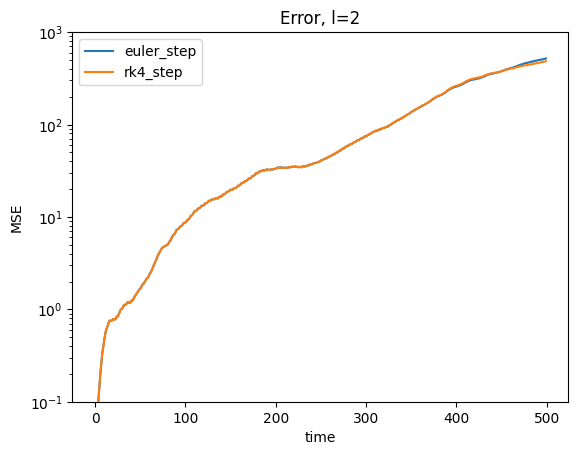

In [ ]:
compare_error(normalized_data[1985], euler_step_ensemble.detach().numpy(), range(eval_steps), "euler_step")
compare_error(normalized_data[1985], rk4_ensemble.detach().numpy(), range(eval_steps), "rk4_step")
plt.title("Error, l=2")
plt.legend()

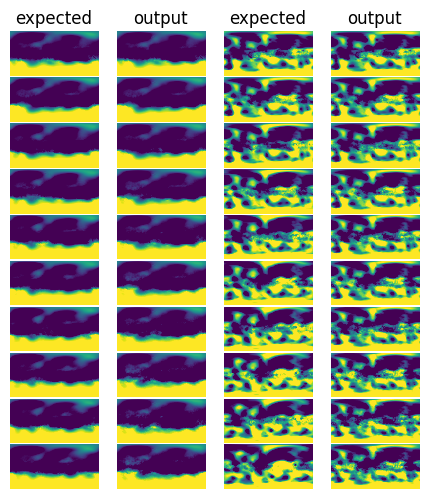

In [ ]:
plt.figure()
visualize_comparison_trend(normalized_data[1985], rk4_ensemble, 10)
plt.tight_layout(pad=0, w_pad=-12, h_pad=0.1)

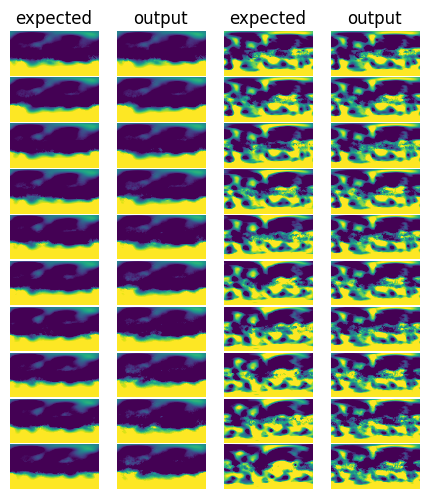

In [ ]:
visualize_comparison_trend(normalized_data[1985], euler_step_ensemble, 10)
plt.tight_layout(pad=0, w_pad=-12, h_pad=0.1)


## 5 previous!!!

In [ ]:
time_series = TimeSeriesDatasetMany(training_data, 5)
training_loader = DataLoader(time_series, batch_size=batch_size, shuffle=True)

In [ ]:
# Training Loop
model_5_ts = ForwardVAE(5).to(device)  # Move model to device (CUDA or CPU)
optimizer = optim.Adam(model_5_ts.parameters(), lr=learning_rate)
for epoch in range(epochs):
  model_5_ts.train()
  train_loss = 0
  # Loop through batches of data
  for batch_idx, (previous_x, x, _) in enumerate(training_loader):
    x = x.to(device).float()
    previous_x = previous_x.to(device).float()
    r = torch.rand((len(x), 1)).to(device).float().reshape(-1, 1)
    # print(x_0.shape)

    optimizer.zero_grad()

    # Forward pass
    out = model_5_ts(previous_x.view(len(x), -1, 91, 180), r)

    loss = F.mse_loss(out, x-previous_x[:,-1])
    loss.backward()

    # Update weights
    optimizer.step()

    train_loss += loss.item()
    # if batch_idx % 100 == 0:
    #     print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(training_loader)}, Loss: {loss.item()/len(data)}")

  print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {train_loss / len(training_loader.dataset)}")
model_5_ts.eval()

Epoch 1/20, Average Loss: 0.002645048333099391
Epoch 2/20, Average Loss: 0.002070469626084054
Epoch 3/20, Average Loss: 0.0019376676990282946
Epoch 4/20, Average Loss: 0.0019029540889122078
Epoch 5/20, Average Loss: 0.0018607595612316185
Epoch 6/20, Average Loss: 0.001817263016838655
Epoch 7/20, Average Loss: 0.0017775880240795852
Epoch 8/20, Average Loss: 0.001725596837516945
Epoch 9/20, Average Loss: 0.0016713839299921957
Epoch 10/20, Average Loss: 0.0016290605362325441
Epoch 11/20, Average Loss: 0.0015991860058009982
Epoch 12/20, Average Loss: 0.00154128089409349
Epoch 13/20, Average Loss: 0.0015015903835448527
Epoch 14/20, Average Loss: 0.0014671720943976233
Epoch 15/20, Average Loss: 0.0014369393756131763
Epoch 16/20, Average Loss: 0.0014129585064443584
Epoch 17/20, Average Loss: 0.0013850422167429922
Epoch 18/20, Average Loss: 0.0013531423498428037
Epoch 19/20, Average Loss: 0.0013310777603696932
Epoch 20/20, Average Loss: 0.001312790177590248


ForwardVAE(
  (conv1): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=35329, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_output): Linear(in_features=1024, out_features=32760, bias=True)
)

In [ ]:
def ensemble_better_5(step, steps, sample_number, model_ensemble):
  model_ensemble_time_series = [
      torch.from_numpy(normalized_data[1985][0]).float().to(device).unsqueeze(0),
      torch.from_numpy(normalized_data[1985][1]).float().to(device).unsqueeze(0),
      torch.from_numpy(normalized_data[1985][2]).float().to(device).unsqueeze(0),
      torch.from_numpy(normalized_data[1985][3]).float().to(device).unsqueeze(0),
      torch.from_numpy(normalized_data[1985][4]).float().to(device).unsqueeze(0),
  ]
  for t in range(steps):
    def L(y):
      ensemble = []
      prev = torch.stack(model_ensemble_time_series[-5:]).view( -1, 91, 180).unsqueeze(0)
      for _ in range(sample_number):
        # print(model_ensemble_time_series[-1].shape, t)
        r = torch.tensor([[random.random()]]).float().to(device)
        r = r.unsqueeze(0)
        output= model_ensemble(prev, r)
        ensemble.append(output.cpu().detach())
      return torch.mean(torch.stack(ensemble), axis=0).to(device)
    if t%200 == 0: print(t)
    model_ensemble_time_series.append(step(model_ensemble_time_series[-1], L).to(device))
  return  torch.stack(model_ensemble_time_series).squeeze(1).cpu()

In [ ]:
eval_steps = 500
sample_number = 10
euler_step_ensemble = ensemble_better_5(euler_step, eval_steps, sample_number, model_5_ts)
rk4_ensemble = ensemble_better_5(rk4_step, eval_steps, sample_number, model_5_ts)

0
200
400
0
200
400


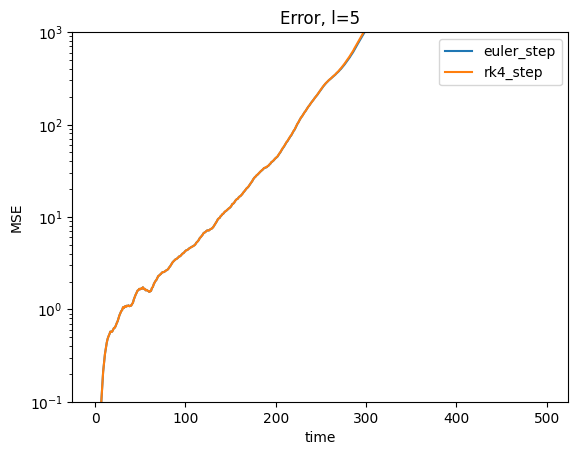

In [ ]:
compare_error(normalized_data[1985], euler_step_ensemble.detach().numpy(), range(eval_steps), "euler_step")
compare_error(normalized_data[1985], rk4_ensemble.detach().numpy(), range(eval_steps), "rk4_step")
plt.title("Error, l=5")
plt.legend()

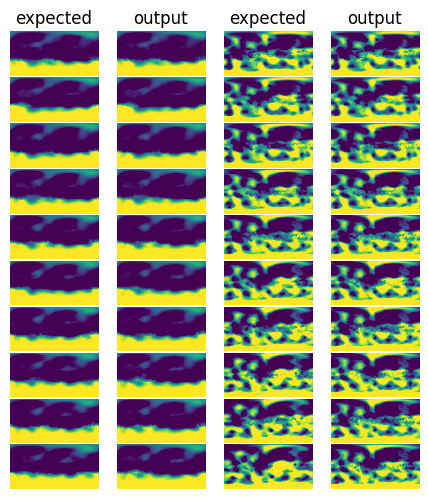

In [ ]:
plt.figure()
visualize_comparison_trend(normalized_data[1985], rk4_ensemble, 10)
plt.tight_layout(pad=0, w_pad=-12, h_pad=0.1)

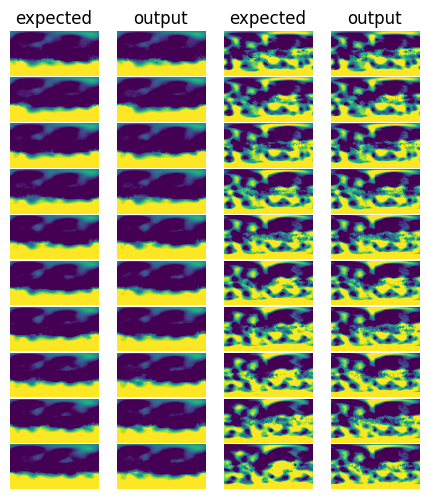

In [ ]:
plt.figure()
visualize_comparison_trend(normalized_data[1985], euler_step_ensemble, 10)
plt.tight_layout(pad=0, w_pad=-12, h_pad=0.1)